In [1]:
import sys
sys.path.append('/users/taoshi11/analysator/')
import pytools as pt
import numpy as np

Using LaTeX formatting
Using backend module://matplotlib_inline.backend_inline
Using matplotlib version 3.8.4


In [2]:
import io_velocity
import matplotlib

# Convert the coordinates of the variable from cartesian (x, y, z) to spherical(r, theta, phi)
def coord_sys_convert(var,coords0):
    var_x, var_y, var_z = var[:,0], var[:,1], var[:,2]
    x, y, z = coords0[:,0], coords0[:,1], coords0[:,2]

    r = np.linalg.norm(coords0, axis = 1)
    # print(z)
    # print(r)
    
    theta = np.arccos(z/r)
    # print(theta)
    # print(z)
    # print(r)
    phi = np.arctan2(y,x)

    var_r = var_x * np.sin(theta) * np.cos(phi) + var_y * np.sin(theta) * np.sin(phi) + var_z * np.cos(theta) # radial direction
    var_theta = -(var_x * np.cos(theta) * np.cos(phi) + var_y * np.cos(theta) * np.sin(phi) - var_z * np.sin(theta)) # meriodinal direction, add negative sign to make it south-north
    var_phi = - var_x * np.sin(phi) + var_y * np.cos(phi) # zonal direction

    return var_r, var_theta, var_phi

# Find barycenter
def get_triangle_barycenter(triangles, mask):
    bary_center = (triangles[mask,0,:] + triangles[mask,1,:] + triangles[mask,2,:])/3
    return bary_center




def plot_io_variables(f, viewdir = 1):
    
    # Read coordinates
    coords = f.get_ionosphere_node_coords()
    # coords = f.read_variable("ig_upmappednodecoords")

    # try:
    #     ionosphere_radius = f.read_parameter("ionosphere_radius")
    # except:
    #     ionosphere_radius = np.max(np.linalg.norm(coords, axis=-1))
    ionosphere_radius = np.max(np.linalg.norm(coords,axis = 1))

    if viewdir > 0:
        theta = np.degrees(np.arccos(coords[:,2]/ionosphere_radius))
    else:
        theta = np.degrees(np.arccos(-coords[:,2]/ionosphere_radius))

    phi = np.arctan2(coords[:,1],coords[:,0])               # Phi in spherical coordinate(r, theta, phi), represent longitude
    # theta = np.arccos(coords[:,2]/ionosphere_radius)        # Theta in (r, theta, phi), represent latitude

    # Construct the grid (latitude, longitude(MLT))
    elements = f.get_ionosphere_element_corners()
    # Project nodes and elements into view plane
    mask = []
    if viewdir > 0:
      for e in elements:
         if coords[e[0],2] > 0 and coords[e[1],2] > 0 and coords[e[2],2] > 0:
            mask+=[False]
         else:
            mask+=[True]
    else:
      for e in elements:
         if coords[e[0],2] < 0 and coords[e[1],2] < 0 and coords[e[2],2] < 0:
            mask+=[False]
         else:
            mask+=[True]

    # Build mesh triangulation 
    # tri = matplotlib.tri.Triangulation(-theta*np.sin(phi), theta*np.cos(phi), elements, mask)
    # one that doesn't rotate
    tri = matplotlib.tri.Triangulation(theta*np.cos(phi), theta*np.sin(phi), elements, mask)

    
    

    # Calculate electric field, drift velocity from the know variables
    B_face0 = io_velocity.get_B_face(f)
    E_face0 = io_velocity.ig_E(f)
    V0 = io_velocity.velocity_E_cross_B(E_face0,B_face0)

    mask2 = ~np.array(mask)

    # V is for northern hemisphere
    B_face = B_face0[mask2,:]
    E_face = E_face0[mask2,:]

    V = io_velocity.velocity_E_cross_B(E_face,B_face)

    # plot the electric field (theta/phi component)
    mask3 = np.full((mask2.shape[0]),True)
    barycenters0 = get_triangle_barycenter(coords[elements,:], mask3)
    barycenters = get_triangle_barycenter(coords[elements,:], mask2)
    theta_bary = np.degrees(np.arccos(barycenters[:,2]/ionosphere_radius))
    phi_bary = np.arctan2(barycenters[:,1],barycenters[:,0])

    # actual coords
    theta_bary_n = -theta_bary * np.sin(phi_bary)
    phi_bary_n = theta_bary * np.cos(phi_bary)

    print(theta_bary.shape)
    
    # print(barycenters)
    E_r, E_theta, E_phi = coord_sys_convert(E_face0, barycenters0)
    V_r, V_theta, V_phi = coord_sys_convert(V0, barycenters0)

    E_spherical = np.concatenate((E_r[:,np.newaxis],E_theta[:,np.newaxis], E_phi[:,np.newaxis]), axis = 1)
    V_spherical = np.concatenate((V_r[:,np.newaxis],V_theta[:,np.newaxis], V_phi[:,np.newaxis]), axis = 1)

    

    # print(coords[elements,:])

    return E_spherical, V_spherical, tri, theta_bary_n, phi_bary_n, barycenters0, V, V0

In [3]:
filepath = '/scratch/project_2000203/3D/FHA/bulk1/'
filename = 'bulk1.0001000.vlsv'
name = filepath+filename
f = pt.vlsvfile.VlsvReader(file_name = name)

Found population proton


In [4]:
E_spherical, V_spherical, tri, theta_bary_n,phi_bary_n, barycenters, V_cartesian, V0_cartesian = plot_io_variables(f, viewdir = 1)

(21477,)


In [5]:
E_spherical.shape

(43132, 3)

In [6]:
import matplotlib.path as mpath
import matplotlib.patches as patches


In [7]:
# # Find the correct coordinates for velocity
# mask_north = np.full((barycenters.shape[0]),True)
# mask_north[barycenters[:,2]<0] = False

# bary_used = barycenters[mask_north,:]
# V_used = V_spherical[mask_north,:]


# coords = f.get_ionosphere_node_coords()
# try:
#     ionosphere_radius = f.read_parameter("ionosphere_radius")
# except:
#     ionosphere_radius = np.max(np.linalg.norm(coords, axis=-1))

# theta_bary = np.degrees(np.arccos(bary_used[:,2]/ionosphere_radius))
# phi_bary = np.arctan2(bary_used[:,1],bary_used[:,0])

# coords_x = -theta_bary * np.sin(phi_bary)
# coords_y = theta_bary * np.cos(phi_bary)





In [8]:
# bary_used[0]/6371000

In [9]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# import matplotlib.colors as mcolors
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import matplotlib.projections as projections

# minlatitude=60
# def make_circle(r):
#     t = np.arange(0, np.pi * 2.0, 0.01)
#     t = t.reshape((len(t), 1))
#     x = r * np.cos(t)
#     y = r * np.sin(t)
#     return np.hstack((x, y))
# path = mpath.Path
# inside_vertices = make_circle(90-minlatitude)
# outside_vertices = make_circle(1000)
# pathCodes = np.ones(len(inside_vertices), dtype=mpath.Path.code_type) * mpath.Path.LINETO
# pathCodes[0] = mpath.Path.MOVETO
# path = mpath.Path(np.concatenate((inside_vertices[::-1],outside_vertices)), np.concatenate((pathCodes,pathCodes)))
# clippingcircle= patches.PathPatch(path, facecolor="#ffffff", edgecolor='grey', linewidth=1)



# # fig = plt.figure()
# fig, (ax_cartesian, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# # ax_cartesian = fig.add_subplot(111)
# # colormap = 'bwr'
# # cmapuse=matplotlib.cm.get_cmap(name=colormap)
# # contours = ax_cartesian.tripcolor(tri, E_spherical[:,1], cmap='bwr',  shading='flat')

# ax_cartesian = fig.add_axes([0.1,0.1,0.9,0.9], xlim=(-(90-minlatitude),(90-minlatitude)), ylim=(-(90-minlatitude),(90-minlatitude)), aspect='equal')
# contours = ax_cartesian.tripcolor(tri, E_spherical[:,1], cmap='bwr',  shading='flat')

# sampling_factor = 5 

# coords = f.get_ionosphere_node_coords()
# try:
#     ionosphere_radius = f.read_parameter("ionosphere_radius")
# except:
#     ionosphere_radius = np.max(np.linalg.norm(coords, axis=-1))

# theta_bary = np.degrees(np.arccos(barycenters[:,2]/ionosphere_radius))
# phi_bary = np.arctan2(barycenters[:,1],barycenters[:,0])

# bary_lati = -theta_bary * np.sin(phi_bary)
# bary_long = theta_bary * np.cos(phi_bary)
# V_theta, V_phi = V_spherical[:,1], V_spherical[:,2]
# V_x = V_cartesian[:,0]
# # ax_polar.quiver(coords_x[::sampling_factor], coords_y[::sampling_factor], V_used[::sampling_factor, 2], V_used[::sampling_factor, 1], color='black')
# density_factor = 5
# bary_lati_reduced = bary_lati[::density_factor]
# bary_long_reduced = bary_long[::density_factor]
# V_theta_reduced = V_theta[::density_factor]
# V_phi_reduced = V_phi[::density_factor]
# V_x_reduced = V_x[::density_factor]

# x_centroids = np.mean(tri.x,)
# y_centroids = np.mean(tri.y, axis=1)

# q = ax_cartesian.quiver(x_centroids, y_centroids, V_x_reduced, 0)
# ax_cartesian.quiverkey(q, X=0.3, Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')


# ax_cartesian.set_xticklabels([])
# ax_cartesian.set_yticklabels([])
# ax_cartesian.axis('off')
# ax_cartesian.add_patch(clippingcircle)

# # Draw polar grid over it
# ax_polar = inset_axes(parent_axes=ax_cartesian, width="100%", height="100%", axes_class = projections.get_projection_class('polar'), borderpad=0)
# ax_polar.set_frame_on(False)
# ax_polar.set_aspect('equal')

# fontsize2=10 # Time title


# ax_polar.grid(True)
# gridlatitudes = np.arange(0., 90.-minlatitude,10.)
# ax_polar.set_rmax(90.-minlatitude)
# ax_polar.set_rgrids(gridlatitudes, map(lambda x: str(90.-x)+"°", gridlatitudes),angle=225)
# ax_polar.set_thetagrids(np.linspace(0., 360, 13), ["24h","2h","4h","6h","8h","10h","12h","14h","16h","18h","20h","22h","24h"])
#     # ax_polar.set_theta_zero_location('W', offset=0)
# ax_polar.set_theta_zero_location('S', offset=0)

# ax_polar.tick_params(labelsize=fontsize2, pad=0.1)


# # # ax_cartesian.quiverkey(q, X=0.3, Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')

# # ax2 = fig.add_subplot(121)

# plt.show()

In [10]:
# tri.triangles
# # tri.mask.shape

In [11]:
# bary_lati.shape

In [12]:
# Preparation for magnetosphere plot
cellids = f.read_variable("CellID")
cellsize = f.read_variable("vg_dx")

coords = f.read_variable("vg_coordinates")
eq_indice = np.where((coords[:,2]<cellsize[:,2]) & (coords[:,2]>0))[0]
cellids_used = cellids[eq_indice]
coords_mag = f.read_variable("vg_coordinates",cellids_used)

In [13]:
def var_cart_to_sphere(var,coord):
    var_x, var_y = var[:,0], var[:,1]
    x, y = coord[:,0], coord[:,1]
    theta = np.arctan2(y,x)
    var_r = var_x * np.cos(theta) + var_y * np.sin(theta)
    var_theta = -var_x * np.sin(theta) + var_y * np.cos(theta)
    return var_r, var_theta

v_mag = f.read_variable("proton/vg_v",cellids_used)
E_mag = f.read_variable("vg_e_vol",cellids_used)
Er_mag,Etheta_mag = var_cart_to_sphere(E_mag,coords_mag)
vr_mag,vtheta_mag = var_cart_to_sphere(v_mag,coords_mag)
flags_mag = f.read_variable("vg_connection", cellids_used)

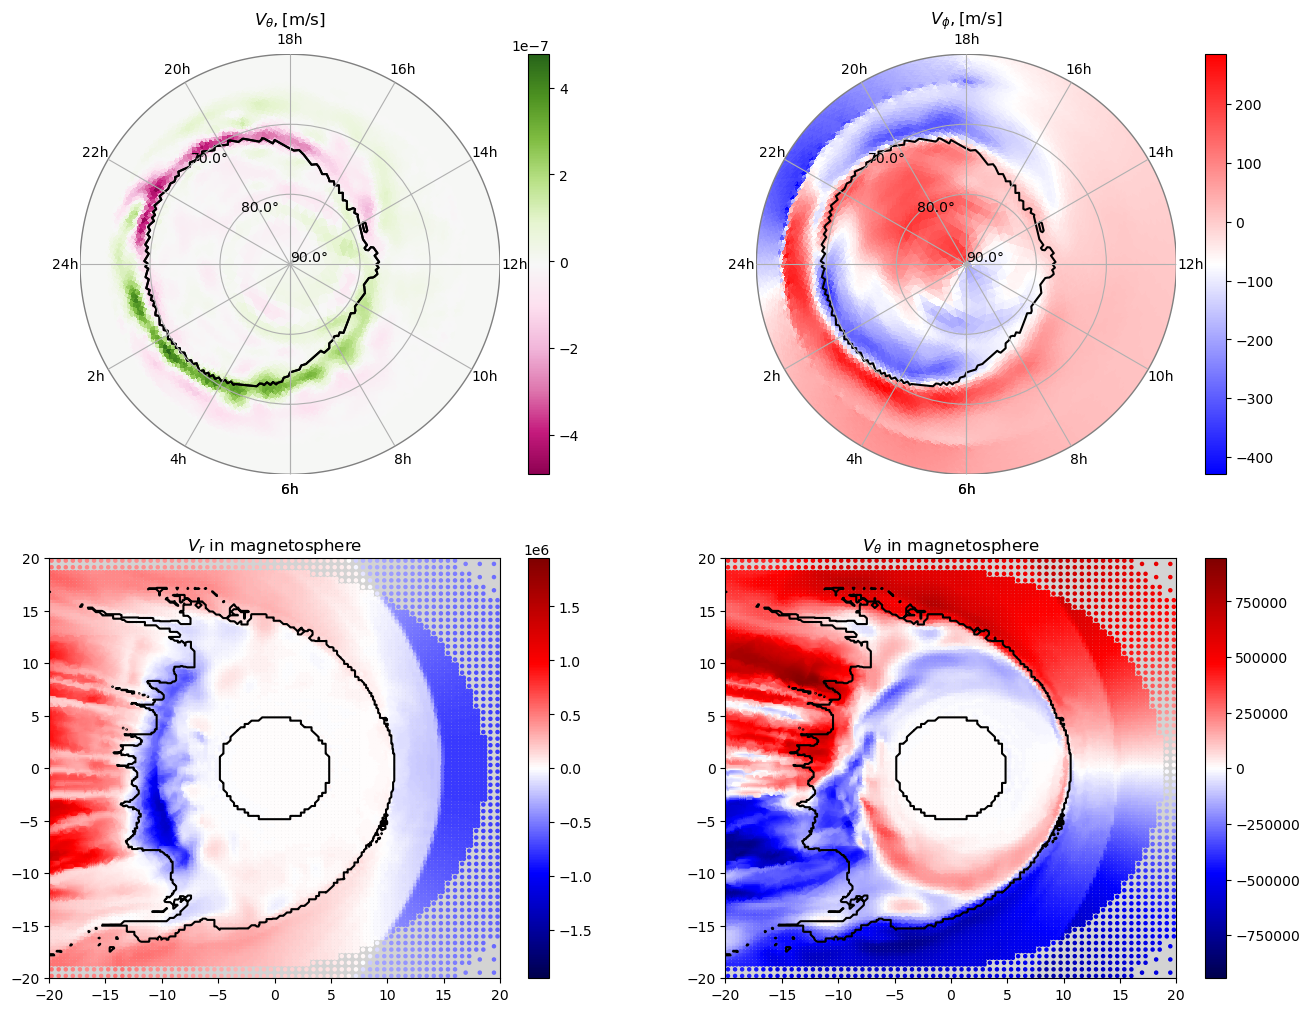

In [14]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.projections as projections
import matplotlib.patches as patches
import matplotlib.path as mpath
import numpy as np

# Assuming io_velocity is a module you have imported
# import io_velocity

# Assuming f is an object that has the necessary data and methods
# f = ...

# Assuming E_spherical, V_spherical, tri, barycenters are already defined
# E_spherical, V_spherical, tri, barycenters = plot_io_variables(f, viewdir=1)

# Assuming plot_io_variables, minlatitude, fontsize2 are defined elsewhere
minlatitude = 60

# Helper function to create a circle path
def make_circle(r):
    t = np.arange(0, np.pi * 2.0, 0.01)
    t = t.reshape((len(t), 1))
    x = r * np.cos(t)
    y = r * np.sin(t)
    return np.hstack((x, y))

path = mpath.Path
inside_vertices = make_circle(90 - minlatitude)
outside_vertices = make_circle(1000)
pathCodes = np.ones(len(inside_vertices), dtype=mpath.Path.code_type) * mpath.Path.LINETO
pathCodes[0] = mpath.Path.MOVETO
path = mpath.Path(np.concatenate((inside_vertices[::-1], outside_vertices)), np.concatenate((pathCodes, pathCodes)))
clippingcircle = patches.PathPatch(path, facecolor="#ffffff", edgecolor='grey', linewidth=1)
clippingcircle2 = patches.PathPatch(path, facecolor="#ffffff", edgecolor='grey', linewidth=1)
clippingcircle3 = patches.PathPatch(path, facecolor="#ffffff", edgecolor='grey', linewidth=1)


fig, [[ax_cartesian,ax2_cartesian],[ax3,ax4]] = plt.subplots(2, 2, figsize=(16, 12))

# Plot on ax_cartesian
ax_cartesian.set_xlim([-(90 - minlatitude), (90 - minlatitude)])
ax_cartesian.set_ylim([-(90 - minlatitude), (90 - minlatitude)])
ax_cartesian.set_aspect('equal')

# contours = ax_cartesian.tripcolor(tri, E_spherical[:, 1], cmap='bwr', shading='flat')

sampling_factor = 5

coords = f.get_ionosphere_node_coords()
fac = f.read_variable("ig_fac")
try:
    ionosphere_radius = f.read_parameter("ionosphere_radius")
except:
    ionosphere_radius = np.max(np.linalg.norm(coords, axis=-1))

# Find the correct coordinates for velocity
# bary_centers = 

mask_north = np.full((barycenters.shape[0]),True)
mask_north[barycenters[:,2]<0] = False

# theta_bary = np.degrees(np.arccos(barycenters[mask_north, 2] / ionosphere_radius))
# phi_bary = np.arctan2(barycenters[mask_north, 1], barycenters[mask_north, 0])


# # bary_lati = 90-theta_bary
# # bary_long = phi_bary

# bary_lati = theta_bary * np.cos(phi_bary)
# bary_long = theta_bary * np.sin(phi_bary)

# V_theta, V_phi = V_spherical[mask_north, 1], V_spherical[mask_north, 2]
Vx ,Vy = V0_cartesian[:,0], V0_cartesian[:,1]

density_factor = 5
# bary_lati_reduced = bary_lati[::density_factor]
# bary_long_reduced = bary_long[::density_factor]

# phi_reduced = phi_bary[::density_factor]
# theta_reduced = theta_bary[::density_factor]

# V_theta_reduced = V_theta[::density_factor]
# V_phi_reduced = V_phi[::density_factor]
Vx_n, Vy_n = V_cartesian[:,0], V_cartesian[:,1]

Vx_reduced = Vx_n[::density_factor]
Vy_reduced = Vy_n[::density_factor]

theta_bary_n_reduced = theta_bary_n[::density_factor]
phi_bary_n_reduced = phi_bary_n[::density_factor]

# contours1 = ax_cartesian.tripcolor(tri, V0_cartesian[:,0], cmap='bwr', shading='flat')
contours1 = ax_cartesian.tripcolor(tri, fac, cmap='PiYG', shading='flat')
cbar1 = plt.colorbar(contours1,ax = ax_cartesian)



# quiver plot
# we need Vx,Vy in the (latitude (theta), longitude (phi)) plane
# Vx = V_theta_reduced * np.cos(bary_long_reduced) - V_phi_reduced * np.sin(bary_long_reduced)
# Vy = V_theta_reduced * np.sin(bary_long_reduced) + V_phi_reduced * np.cos(bary_long_reduced)

# q = ax_cartesian.quiver(bary_long_reduced,bary_lati_reduced, Vx, Vy)

# q = ax_cartesian.quiver(bary_lati_reduced,bary_long_reduced, Vx_reduced,Vy_reduced)
# q = ax_cartesian.quiver(bary_lati_reduced,bary_long_reduced, V_theta_reduced, V_phi_reduced)

# q2 = ax_cartesian.quiver(theta_bary_n_reduced,phi_bary_n_reduced,0,Vx_reduced)

# q2 = ax_cartesian.quiver(phi_bary_n_reduced,theta_bary_n_reduced,0,Vx_reduced)
# ax_cartesian.quiverkey(q, X=0.3, Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')

flags = f.read_variable("ig_openclosed")
ax_cartesian.set_facecolor('lightgrey')
OCB = ax_cartesian.tricontour(tri, flags, levels=[0.5], colors='black')

ax_cartesian.set_xticklabels([])
ax_cartesian.set_yticklabels([])
ax_cartesian.axis('off')
ax_cartesian.add_patch(clippingcircle)

# Draw polar grid over it on ax_polar_subplot
ax_polar = inset_axes(parent_axes=ax_cartesian, width="100%", height="100%", axes_class=projections.get_projection_class('polar'), borderpad=0)
ax_polar.set_frame_on(False)
ax_polar.set_aspect('equal')

fontsize2 = 10  # Time title

ax_polar.grid(True)
gridlatitudes = np.arange(0., 90. - minlatitude, 10.)
ax_polar.set_rmax(90. - minlatitude)
ax_polar.set_rgrids(gridlatitudes, [str(90. - x) + "°" for x in gridlatitudes], angle=225)
# ax_polar.set_thetagrids(np.linspace(0., 360, 13), ["24h", "2h", "4h", "6h", "8h", "10h", "12h", "14h", "16h", "18h", "20h", "22h", "24h"])
ax_polar.set_thetagrids(np.linspace(0., 360, 13), ["6h", "8h", "10h", "12h", "14h", "16h", "18h", "20h", "22h", "24h", "2h", "4h", "6h"])
ax_polar.set_theta_zero_location('S', offset=0)
ax_polar.tick_params(labelsize=fontsize2, pad=0.1)

ax_polar.set_title(r"$V_\theta, \mathrm{[m/s]}$")


# Here starts ax2

ax2_cartesian.set_xlim([-(90 - minlatitude), (90 - minlatitude)])
ax2_cartesian.set_ylim([-(90 - minlatitude), (90 - minlatitude)])
ax2_cartesian.set_aspect('equal')

# contours2 = ax2_cartesian.tripcolor(tri, V0_cartesian[:,1], cmap='bwr', shading='flat')
contours2 = ax2_cartesian.tripcolor(tri, V_spherical[:,2], cmap='bwr', shading='flat')
OCB2 = ax2_cartesian.tricontour(tri, flags, levels=[0.5], colors='black')
cbar1 = plt.colorbar(contours2,ax = ax2_cartesian)

V_tp = np.sqrt(Vy_reduced **2 + Vx_reduced **2)

# quiver plot
# q2 = ax2_cartesian.quiver(theta_bary_n_reduced,phi_bary_n_reduced,-Vy_reduced,0*Vx_reduced, V_tp)

# q2 = ax2_cartesian.quiver(theta_bary_n_reduced,phi_bary_n_reduced,-Vy_reduced,0*Vx_reduced)

# q2 = ax2_cartesian.quiver(phi_bary_n_reduced,theta_bary_n_reduced,-Vy_reduced,0*Vx_reduced)
# q2 = ax2_cartesian.quiver(phi_bary_n_reduced,theta_bary_n_reduced, Vx_reduced,0*Vy_reduced)
# q2 = ax2_cartesian.quiver(bary_lati_reduced,bary_long_reduced, Vx_reduced,0*Vy_reduced)

flags = f.read_variable("ig_openclosed")
ax_cartesian.set_facecolor('lightgrey')
OCB = ax_cartesian.tricontour(tri, flags, levels=[0.5], colors='black')

ax2_cartesian.set_xticklabels([])
ax2_cartesian.set_yticklabels([])
ax2_cartesian.axis('off')
ax2_cartesian.add_patch(clippingcircle2)

# Draw polar grid over it on ax_polar_subplot
ax2_polar = inset_axes(parent_axes=ax2_cartesian, width="100%", height="100%", axes_class=projections.get_projection_class('polar'), borderpad=0)
ax2_polar.set_frame_on(False)
ax2_polar.set_aspect('equal')

fontsize2 = 10  # Time title

ax2_polar.grid(True)
gridlatitudes = np.arange(0., 90. - minlatitude, 10.)
ax2_polar.set_rmax(90. - minlatitude)
ax2_polar.set_rgrids(gridlatitudes, [str(90. - x) + "°" for x in gridlatitudes], angle=225)
# ax2_polar.set_thetagrids(np.linspace(0., 360, 13), ["24h", "2h", "4h", "6h", "8h", "10h", "12h", "14h", "16h", "18h", "20h", "22h", "24h"])
ax2_polar.set_thetagrids(np.linspace(0., 360, 13), ["6h", "8h", "10h", "12h", "14h", "16h", "18h", "20h", "22h", "24h", "2h", "4h", "6h"])
ax2_polar.set_theta_zero_location('S', offset=0)
ax2_polar.tick_params(labelsize=fontsize2, pad=0.1)

ax2_polar.set_title(r"$V_\phi, \mathrm{[m/s]}$")

Re = 6371000
ax3.set_facecolor('lightgrey')
vmin3 = -vr_mag.max()
vmax3 = vr_mag.max()
norm3 = mcolors.TwoSlopeNorm(vmin=vmin3, vcenter=0, vmax=vmax3)
scatter3 = ax3.scatter(coords_mag[:,0]/Re,coords_mag[:,1]/Re,c=vr_mag, norm = norm3,cmap = 'seismic',s = 5)

x_mag = coords_mag[:,0]/Re
y_mag = coords_mag[:,1]/Re
contour = ax3.tricontour(x_mag, y_mag, flags_mag, levels=[0.5], colors='black')
ax3.set_xlim([-20,20])
ax3.set_ylim([-20,20])
colorbar = plt.colorbar(scatter3,ax=ax3)
ax3.set_title(r'$V_r$ in magnetosphere')

ax4.set_facecolor('lightgrey')
vmin4 = -vtheta_mag.max()
vmax4 = vtheta_mag.max()
norm4 = mcolors.TwoSlopeNorm(vmin=vmin4, vcenter=0, vmax=vmax4)
scatter4 = ax4.scatter(x_mag,y_mag,c=vtheta_mag, norm = norm4,cmap = 'seismic',s = 5)

contour4 = ax4.tricontour(x_mag, y_mag, flags_mag, levels=[0.5], colors='black')
ax4.set_xlim([-20,20])
ax4.set_ylim([-20,20])
colorbar = plt.colorbar(scatter4,ax=ax4)
ax4.set_title(r'$V_\theta$ in magnetosphere')




plt.show()


In [15]:

# v_phi = np.load("v_phi_1000.npy")
# pts = np.load("points_1000.npy")
# tris = np.load("triangles_1000.npy")
# tri = mpl.tri.Triangulation(pts[0],pts[1],tris)
np.save("mask_1000.npy",tri.mask)

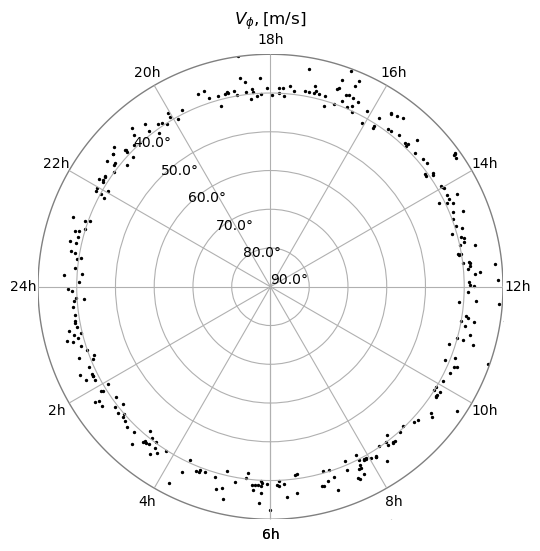

In [16]:
minlatitude = 30

# Helper function to create a circle path
def make_circle(r):
    t = np.arange(0, np.pi * 2.0, 0.01)
    t = t.reshape((len(t), 1))
    x = r * np.cos(t)
    y = r * np.sin(t)
    return np.hstack((x, y))

path = mpath.Path
inside_vertices = make_circle(90 - minlatitude)
outside_vertices = make_circle(1000)
pathCodes = np.ones(len(inside_vertices), dtype=mpath.Path.code_type) * mpath.Path.LINETO
pathCodes[0] = mpath.Path.MOVETO
path = mpath.Path(np.concatenate((inside_vertices[::-1], outside_vertices)), np.concatenate((pathCodes, pathCodes)))

clippingcircle = patches.PathPatch(path, facecolor="#ffffff", edgecolor='grey', linewidth=1)

fig, ax_cartesian = plt.subplots(1, 1, figsize=(6, 9))

ax_cartesian.set_xlim([-(90 - minlatitude), (90 - minlatitude)])
ax_cartesian.set_ylim([-(90 - minlatitude), (90 - minlatitude)])
ax_cartesian.set_aspect('equal')

# contours2 = ax2_cartesian.tripcolor(tri, V0_cartesian[:,1], cmap='bwr', shading='flat')
# contours = ax_cartesian.tripcolor(tri, V_spherical[:,2], cmap='bwr', shading='flat')
# OCB = ax_cartesian.tricontour(tri, flags, levels=[0.5], colors='black')
# cbar = plt.colorbar(contours,ax = ax_cartesian)

V_tp = np.sqrt(Vy_reduced **2 + Vx_reduced **2)

# quiver plot
# q2 = ax2_cartesian.quiver(theta_bary_n_reduced,phi_bary_n_reduced,-Vy_reduced,0*Vx_reduced, V_tp)

# q2 = ax2_cartesian.quiver(theta_bary_n_reduced,phi_bary_n_reduced,-Vy_reduced,0*Vx_reduced)

# q2 = ax2_cartesian.quiver(phi_bary_n_reduced,theta_bary_n_reduced,-Vy_reduced,0*Vx_reduced)
# q2 = ax2_cartesian.quiver(phi_bary_n_reduced,theta_bary_n_reduced, Vx_reduced,0*Vy_reduced)
# q2 = ax2_cartesian.quiver(bary_lati_reduced,bary_long_reduced, Vx_reduced,0*Vy_reduced)

flags = f.read_variable("ig_openclosed")
ax_cartesian.set_facecolor('lightgrey')
# OCB = ax_cartesian.tricontour(tri, flags, levels=[0.5], colors='black')

coords_isocontour = np.load("../Az_Main_Channel/coords_long_lat.npy")
ax_cartesian.scatter(coords_isocontour[:,0],coords_isocontour[:,1],s = 2,color  = 'black')

ax_cartesian.set_xticklabels([])
ax_cartesian.set_yticklabels([])
ax_cartesian.axis('off')
ax_cartesian.add_patch(clippingcircle)

# Draw polar grid over it on ax_polar_subplot
ax_polar = inset_axes(parent_axes=ax_cartesian, width="100%", height="100%", axes_class=projections.get_projection_class('polar'), borderpad=0)
ax_polar.set_frame_on(False)
ax_polar.set_aspect('equal')

fontsize2 = 10  # Time title

# ax_polar.scatter(coords_isocontour[:,0],coords_isocontour[:,1],s = 2,color  = 'black')
ax_polar.grid(True)
gridlatitudes = np.arange(0., 90. - minlatitude, 10.)
ax_polar.set_rmax(90. - minlatitude)
ax_polar.set_rgrids(gridlatitudes, [str(90. - x) + "°" for x in gridlatitudes], angle=225)
# ax2_polar.set_thetagrids(np.linspace(0., 360, 13), ["24h", "2h", "4h", "6h", "8h", "10h", "12h", "14h", "16h", "18h", "20h", "22h", "24h"])
ax_polar.set_thetagrids(np.linspace(0., 360, 13), ["6h", "8h", "10h", "12h", "14h", "16h", "18h", "20h", "22h", "24h", "2h", "4h", "6h"])
ax_polar.set_theta_zero_location('S', offset=0)
ax_polar.tick_params(labelsize=fontsize2, pad=0.1)

ax_polar.set_title(r"$V_\phi, \mathrm{[m/s]}$")

# ax_cartesian.scatter(0,-17,color = 'yellow')

plt.show()

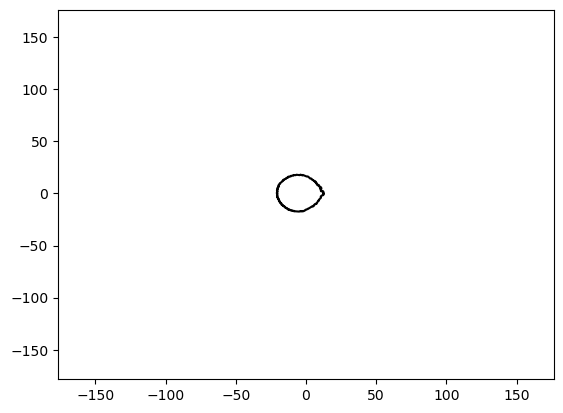

In [17]:
plt.tricontour(tri, flags, levels=[0.5], colors='black')
plt.show()

In [18]:
io_c = f.get_ionosphere_node_coords()

In [19]:
io_c[io_c[:,2]>0].shape

(10784, 3)

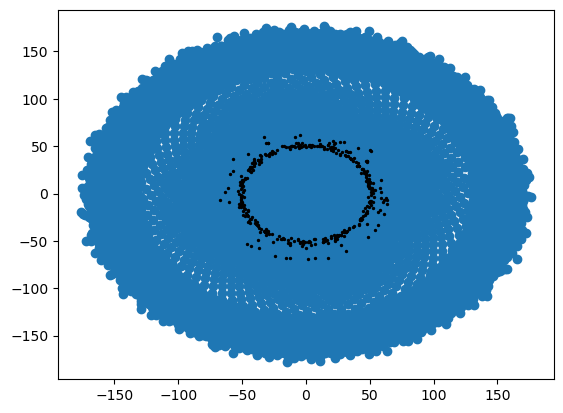

In [20]:
xx, yy = tri.x, tri.y
plt.scatter(xx,yy)
plt.scatter(coords_isocontour[:,0],coords_isocontour[:,1],s = 2,color  = 'black')
plt.show()